## Imports


In [3]:
from dataloader import GScan_BB
from model import BB_model
from loss import CustomMaskedMSELoss,CustomIOU
from torch.utils.data import Dataset, random_split, DataLoader,ConcatDataset
import torch
from torch.nn import BCELoss

from tqdm import tqdm


import wandb
import random
from datetime import datetime

In [4]:
import pandas as pd
import numpy as np
from scipy import stats

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# import urllib.request
import requests

# from sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, roc_curve,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay




import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

## Getting model output

### Data

In [6]:
BATCH_SIZE=16
num_workers=1

full_data = GScan_BB('./data_square_hit/')

# Split proportions
train_ratio = 0.8  # 80% for training


# Calculate split sizes
total_size = len(full_data)
train_size = int(train_ratio * total_size)
val_size = total_size - train_size

# Randomly split the dataset
train_data, val_data = random_split(full_data, [train_size, val_size])

# DataLoader for training and validation sets
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# model= MuonClassifier()
model = BB_model()
model.load_state_dict(torch.load('weights/linear1_2024-11-04_02-43-03.pth'))
model.to(device=device)


# loss=BCELoss()
loss=CustomMaskedMSELoss()
eval_iou=CustomIOU()

cuda


In [8]:
print(len(train_data)+len(val_data))

5196


### Predicting


In [9]:
all_labels = []
all_outputs = []

sample_input=val_data[0]['input'].unsqueeze(0)
print(sample_input.shape)
with torch.no_grad():
    for i, data in enumerate( tqdm(val_dataloader)):
        input=data['input'].to(device=device) 
    
    
        label=data['label'].to(device=device)


        output=model(input)

        all_labels.append(label)
        all_outputs.append(output)

        val_loss=loss(output,label)
        val_iou=eval_iou(output,label)

all_labels = torch.cat(all_labels, dim=0)
all_outputs = torch.cat(all_outputs, dim=0)


torch.Size([1, 12, 180])


  0%|          | 0/65 [00:00<?, ?it/s]

100%|██████████| 65/65 [00:02<00:00, 27.64it/s]


In [10]:
all_labels = []
all_outputs = []
iou_scores = []

sample_input = val_data[0]['input'].unsqueeze(0)
print(sample_input.shape)

# Loop through the validation data
with torch.no_grad():
    for i, data in enumerate(tqdm(val_dataloader)):
        input = data['input'].to(device=device)
        label = data['label'].to(device=device)

        # Get the model's output
        output = model(input)

        # Calculate the loss and IoU
        val_loss = loss(output, label)
        val_iou = eval_iou(output, label)

        # Append the label, output, and IoU score
        all_labels.append(label)
        all_outputs.append(output)
        iou_scores.append(val_iou)

# Convert lists to tensors
all_labels = torch.cat(all_labels, dim=0)
all_outputs = torch.cat(all_outputs, dim=0)
iou_scores = torch.tensor(iou_scores)

# Sort the predictions by IoU score (high to low)
sorted_indices = torch.argsort(iou_scores, descending=True)

# Sort all_labels, all_outputs, and iou_scores using the sorted indices
sorted_labels = all_labels[sorted_indices]
sorted_outputs = all_outputs[sorted_indices]
sorted_iou_scores = iou_scores[sorted_indices]

torch.Size([1, 12, 180])


100%|██████████| 65/65 [00:02<00:00, 29.69it/s]


In [47]:
all_labels.shape


torch.Size([1029, 6, 4])

In [48]:
all_outputs.shape

torch.Size([1029, 6, 4])

### Confusion matrix

### ROC curve and AUC score

[804 996]


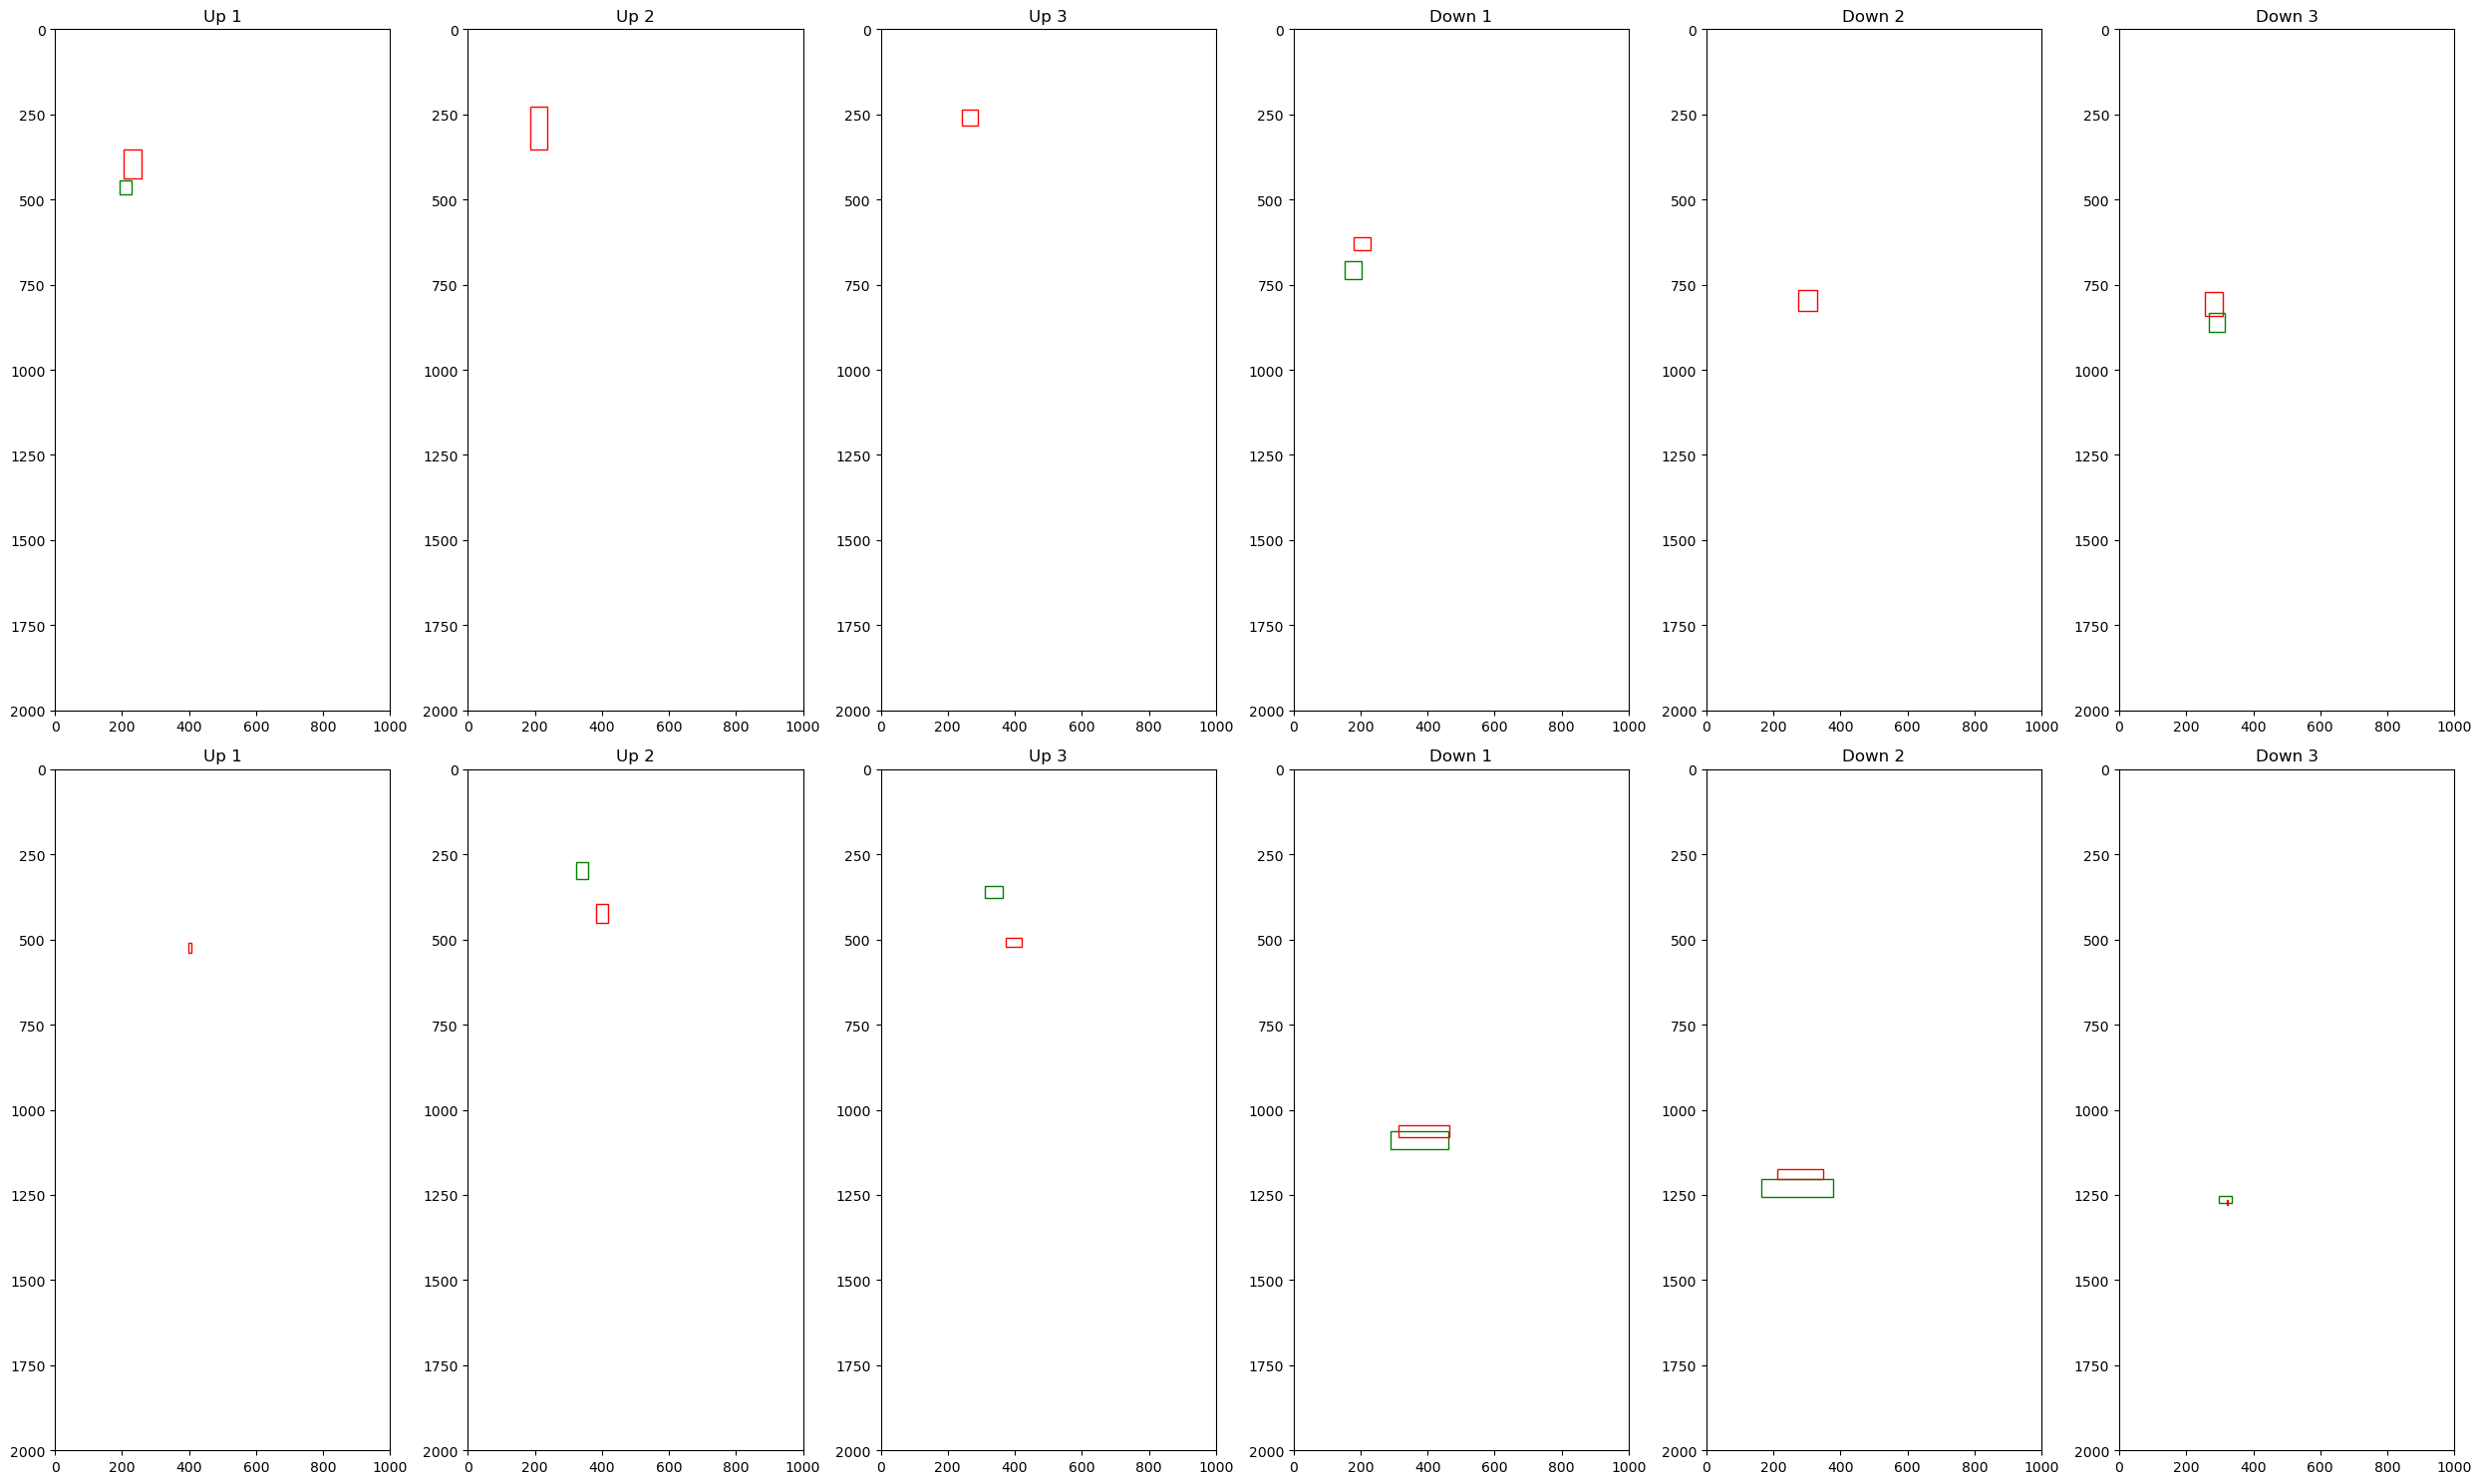

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch


# Number of matrices to visualize
num_matrices = 6
no_sample=2


titles = ["Up 1", "Up 2", "Up 3", "Down 1", "Down 2", "Down 3"]
# Create a figure with 1 row and 6 columns for the images
fig, axes = plt.subplots(no_sample, num_matrices, figsize=(25, 15))
# 41 643 691 897 105
# 89 307 539 332 553
#847 338 362 156 945
#854+ 791+ 951
#77
samples=np.random.randint(1, len(all_labels), size=no_sample)
print(samples)
# Iterate through each matrix and corresponding axes
for ins in range(no_sample):
    for mat_no in range(num_matrices):
        mat_o = all_outputs[samples[ins]][mat_no].cpu()  # Select matrix
        mat_p =  all_labels[samples[ins]][mat_no].cpu()


        # Extract x and y limits (min and max)
        # For ground truth
        x_centre_p = mat_p[0]
        y_centre_p = mat_p[1]
        width_p = mat_p[2]
        height_p = mat_p[3]

        x_lower_left_p = x_centre_p - width_p / 2
        y_lower_left_p = y_centre_p - height_p / 2
        
        # For predictions
        x_centre_o = mat_o[0]
        y_centre_o = mat_o[1]
        width_o = mat_o[2]
        height_o = mat_o[3]

        x_lower_left_o = x_centre_o - width_o / 2
        y_lower_left_o = y_centre_o - height_o / 2
        
        # Set the limits for the axes
        axes[ins, mat_no].set_xlim(0, 1000)
        axes[ins, mat_no].set_ylim(0, 2000)
        axes[ins, mat_no].invert_yaxis()  # Flip y-axis to align with rectangle coordinates

        # Create rectangle patches for ground truth and prediction
        rectangle_p = patches.Rectangle((x_lower_left_p, y_lower_left_p), width_p, height_p,
                                         linewidth=1, edgecolor='g', facecolor='none', label='Ground Truth')
        rectangle_o = patches.Rectangle((x_lower_left_o, y_lower_left_o), width_o, height_o,
                                         linewidth=1, edgecolor='r', facecolor='none', label='Prediction')
        
        # Add rectangles to the current axes
        axes[ins, mat_no].add_patch(rectangle_p)
        axes[ins, mat_no].add_patch(rectangle_o)




        # Set title and legend for each subplot
        axes[ins, mat_no].set_title(titles[mat_no])
        # axes[ins, mat_no].legend()
        
        # Remove axis labels for a cleaner display
        # axes[mat_no].axis('off')

# Show all images with rectangles side by side
plt.tight_layout()
plt.show()